In [2]:
from __future__ import print_function
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
#%matplotlib inline
from matplotlib import colors
from IPython import display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Figure, Layout

import numpy as np
import time
import math

from poisson import *
from fun1d import *

In [50]:
# sample data from differenct constant possion distribution

# initialize parameters
n = 2**12
m = 2
l = 0.005
pi = math.pi
max_err = 1e-8
max_epoch = 1
epsilon = 1e-4
optim_pars = [max_err, max_epoch]

# define filters
sigma = determine_sigma(epsilon)
Q = 1
alpha = 2
# J = determine_J(n, Q, sigma, alpha)
J = 7
s = np.unique(np.floor(2 ** np.linspace(0, J, int(J*Q)+1)))
# xi = np.arange(1,3) * pi / 3
nxi = 2
xi = np.random.choice(n, nxi) * pi / n
g, g_hat = gabor_wave_family_1d(n, s, xi, sigma)

n_wave = g_hat.shape[1]*g_hat.shape[2]

x_dim = n
ndata = 10000

# sx_dim = 1 + n_wave + n_wave**2 # zero + 1st + 2nd order
t = np.linspace(0, x_dim + 1, x_dim + 1)
mu = 1
x_data = np.zeros((ndata, x_dim)) # signals
# sx_data = np.zeros((ndata, sx_dim)) # scattering coefficients
# y_data = np.zeros((ndata, 10)) # labels(for lambda)


for i in range(ndata):
#     j = np.random.choice(10,1)
    j = 0
    lamb = l * (j + 1)
    x = sample_compound_poisson(t, lamb,'const',mu)
    x_data[i,:] = np.diff(x)
#     sx = scat_infreq_1d(x_data[i,:], g_hat, m)
#     sx_data[i,:] = np.asarray([sx[0]] + list(sx[1]) + list(sx[2].flatten()))
#     y_data[i,j] = 1
np.save('x0_data', x_data)
x = x_data
# np.save('sx_data', sx_data)
# np.save('y_data', y_data)


x = np.load('x_data.npy')
# sx_data = np.load('sx_data.npy')
# y_data = np.load('y_data.npy')

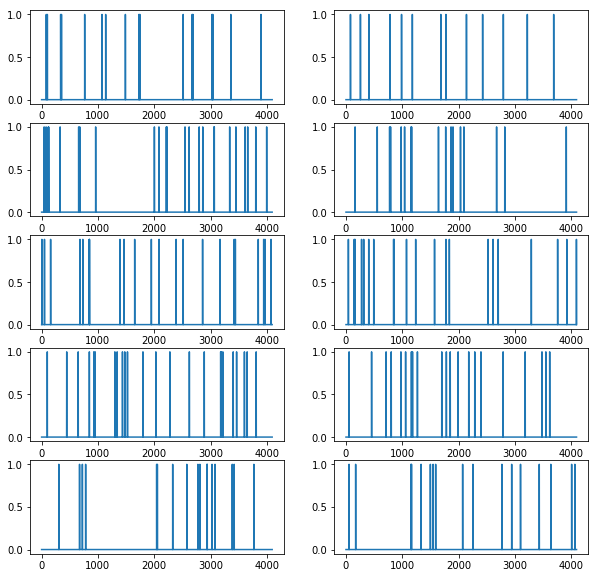

In [53]:
count = 1
fig = plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,2,count)
    plt.plot(x[i,:])
    count += 1

In [33]:
x_data = torch.from_numpy(np.reshape(x,[-1,1,2**12])).float()

In [3]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1, out_channels=128, kernel_size=8, 
                stride=4, padding=2, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=128, out_channels=256, kernel_size=8,
                stride=4, padding=2, bias=False
            ),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(
                in_channels=256, out_channels=512, kernel_size=8,
                stride=4, padding=2, bias=False
            ),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(
                in_channels=512, out_channels=1024, kernel_size=8,
                stride=4, padding=2, bias=False
            ),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*16)
        x = self.out(x)
        return x

In [11]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*16)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=1024, out_channels=512, kernel_size=8,
                stride=4, padding=2, bias=False
            ),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=512, out_channels=256, kernel_size=8,
                stride=4, padding=2, bias=False
            ),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=256, out_channels=128, kernel_size=8,
                stride=4, padding=2, bias=False
            ),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=128, out_channels=1, kernel_size=8,
                stride=4, padding=2, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 16)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    


In [5]:
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

def plot_signals(ntest, n_batch, signals):
    n = 16
    fig = plt.figure(figsize = (10,10))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.plot(signals[i,:])
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.show()
    time.sleep(1)
    plt.savefig('syn_pois%s_%s'%(ntest, n_batch // 100))
    
# def plot_distributions(n_batch, test_images, d_error, d_pred_real, d_pred_fake, g_error):
#         fig = plt.figure(figsize = (15,5))
#         font = {'size':20}
#         ax1 = fig.add_subplot(131)
#         ax1.imshow(test_images.numpy().reshape(16,64,64)[0,:,:])
# #         plt.show()
        
#         ax2 = fig.add_subplot(132)
#         ax2.plot(np.arange(n_batch+1), np.array(d_error), label='dis loss')
#         ax2.plot(np.arange(n_batch+1), np.array(g_error), label='gen loss')
#         ax2.set_title('GAN Loss',font)
#         ax2.set_xlabel('Iterations',font)
#         ax2.set_ylabel('Loss',font)
#         ax2.legend()
        
#         ax3 = fig.add_subplot(133)
#         ax3.plot(np.arange(n_batch+1), np.array(d_pred_real), label='real score')
#         ax3.plot(np.arange(n_batch+1), np.array(d_pred_real), label='fake score')
#         ax3.set_title('GAN Scores',font)
#         ax3.set_xlabel('Iterations',font)
#         ax3.set_ylabel('Score',font)
#         ax3.legend()
# #         plt.tight_layout()
        
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

#         time.sleep(1)



In [18]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200
num_test_samples = 16
test_noise = noise(num_test_samples)
# logger = Logger(model_name='DCGAN', data_name='MNIST')
d_error_sum = []
g_error_sum = []
fake_score_sum = []
real_score_sum = []
ntest = 0

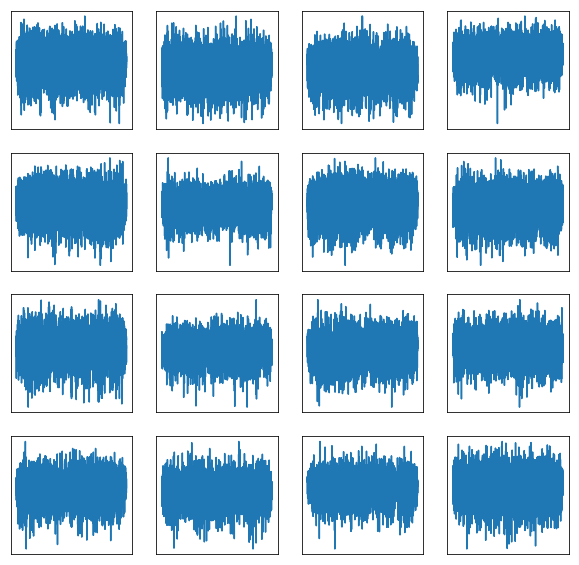

idx: 1
idx: 2


KeyboardInterrupt: 

In [20]:
for epoch in range(num_epochs):
    for idx in range(600):
        print('idx:',idx)
        real_batch = x_data[idx * 100:(idx + 1)*100, :]
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        d_error_sum.append(torch.mean(d_error).data.cpu())
        g_error_sum.append(torch.mean(g_error).data.cpu())
        fake_score_sum.append(torch.mean(d_pred_fake).data.cpu())
        real_score_sum.append(torch.mean(d_pred_real).data.cpu())
        
        # Display Progress
        if idx % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_signals = generator(test_noise).squeeze(1).data.cpu().numpy()
            plot_signals(epoch, idx, test_signals)
            
#             plot_distributions(n_batch, test_images, d_error_sum, real_score_sum, 
#                                fake_score_sum, g_error_sum)
#             torch.save(real_score_sum, 'score_real_%s'%ntest)
#             torch.save(fake_score_sum, 'score_fake_%s'%ntest)
#             torch.save(g_error_sum, 'loss_gen_%s'%ntest)
#             torch.save(d_error_sum, 'loss_dis_%s'%ntest)
#             torch.save(discriminator.state_dict(), 'GAN_MINST_DISC%s'%(ntest))
#             torch.save(generator.state_dict(), 'GAN_MINST_GEN%s'%(ntest))

In [6]:
import torch._utils
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2

TypeError: only 1-element tensors can be converted to Python scalars

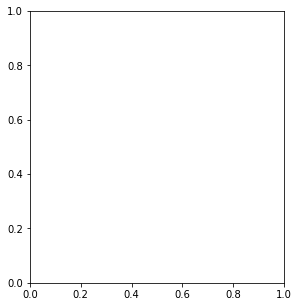

In [7]:
score_real = torch.load('pois_score_real_0')
score_fake = torch.load('pois_score_fake_0')
loss_gen = torch.load('pois_loss_gen_0')
loss_dis = torch.load('pois_loss_dis_0')

fig = plt.figure(figsize = (10,5))
font = {'size':20}
nsteps = len(loss_gen)

ax2 = fig.add_subplot(121)
ax2.plot(np.arange(nsteps), np.array(loss_dis), label='dis loss')
ax2.plot(np.arange(nsteps), np.array(loss_gen), label='gen loss')
ax2.set_title('GAN Loss',font)
ax2.set_xlabel('Iterations',font)
ax2.set_ylabel('Loss',font)
ax2.legend()

ax3 = fig.add_subplot(122)
ax3.plot(np.arange(nsteps), np.array(score_real), label='real score')
ax3.plot(np.arange(nsteps), np.array(score_fake), label='fake score')
ax3.set_title('GAN Scores',font)
ax3.set_xlabel('Iterations',font)
ax3.set_ylabel('Score',font)
ax3.legend()

In [8]:
score_real = torch.load( 'pois_score_real_0')

In [24]:
nbatch = 16
nz = 100
epsilon = torch.randn(nbatch,nz,1,1)
epsilon = Variable(epsilon, requires_grad=False)
g = GenerativeNet()
# model = torch.load('pois_GAN_MINST_GEN0',map_location=lambda storage, loc: storage)
# model.key()
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in model.items():
#     name = k[7:] # remove module.
#     new_state_dict[name] = v

# g.load_state_dict(new_state_dict)
g.load_state_dict(torch.load('pois_GAN_MINST_GEN0', map_location=lambda storage, loc: storage))
g.eval()
fake = g(epsilon)

KeyError: 'unexpected key "conv1.1.num_batches_tracked" in state_dict'

In [18]:
model

OrderedDict([('linear.weight', 
               4.8458e-03 -5.5802e-02 -4.7687e-02  ...  -5.6178e-02 -5.2916e-02 -5.7098e-02
               1.8595e-02 -1.5688e-02  7.3162e-02  ...  -2.7204e-02  8.8311e-03  7.6361e-03
               5.6133e-02  1.8019e-02 -6.2642e-02  ...  -4.7496e-04  5.5326e-02  3.1000e-02
                              ...                   ⋱                   ...                
               8.1162e-02  4.4209e-03 -7.0265e-02  ...  -1.2012e-03  5.7675e-02  7.7157e-02
               4.1823e-02  2.3108e-02  1.9834e-02  ...  -2.2654e-02 -4.8169e-02  4.3222e-02
               5.6942e-02 -8.3340e-03  4.4431e-02  ...  -8.3971e-02  6.2193e-02  7.5470e-02
              [torch.FloatTensor of size 16384x100]), ('linear.bias', 
               0.0765
               0.0487
              -0.1125
                 ⋮   
              -0.1835
              -0.2217
               0.2546
              [torch.FloatTensor of size 16384]), ('conv1.0.weight', 
              ( 0  ,.,.) = 
 